# Importing Libraries 

In [17]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm  # Progress bar
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import random_split

warnings.filterwarnings("ignore")

print("✅ Modules Loaded!")

✅ Modules Loaded!


# Load and preprocess data

In [18]:
train_dir = "C:/Users/konde/OneDrive/Desktop/learn/term paper/ECG_DATA/train"
test_dir = "C:/Users/konde/OneDrive/Desktop/learn/term paper/ECG_DATA/test"


# Updated image transformations (Resize to match ECG image size)
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Keep original ECG image size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize ECG images
])

# Load datasets
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Split train dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check class names
num_classes = len(full_train_dataset.classes)
print("✅ Classes Found:", full_train_dataset.classes)
print(f"✅ Dataset Split: {train_size} training samples, {val_size} validation samples")


✅ Classes Found: ['ECG Images of Myocardial Infarction Patients (240x12=2880)', 'ECG Images of Patient that have History of MI (172x12=2064)', 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'Normal Person ECG Images (284x12=3408)']
✅ Dataset Split: 2418 training samples, 605 validation samples


# Sample images from dataset

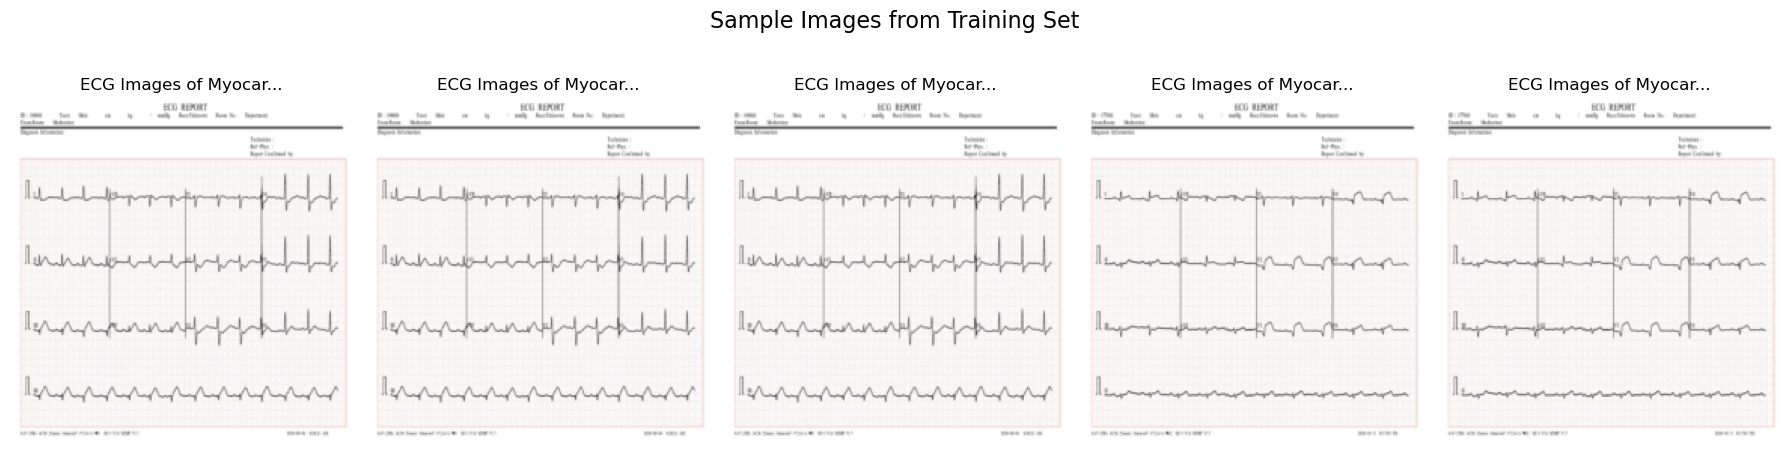

In [19]:
import matplotlib.pyplot as plt

# Adjusted function to handle long class names
def show_sample_images(dataset, title="Sample Images from Dataset"):
    fig, axes = plt.subplots(1, 5, figsize=(18, 5))  # Increase figure size
    for i in range(5):
        image, label = dataset[i]
        image = image.permute(1, 2, 0).numpy()  # Convert from Tensor to NumPy
        image = (image * 0.5) + 0.5  # Denormalize
        
        axes[i].imshow(image)
        class_label = full_train_dataset.classes[label]
        truncated_label = class_label[:20] + "..." if len(class_label) > 20 else class_label  # Limit label length
        axes[i].set_title(truncated_label, fontsize=12)  # Reduce font size
        axes[i].axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()  # Improve spacing
    plt.show()

# Call function
show_sample_images(full_train_dataset, title="Sample Images from Training Set")

# Count of images per class

In [20]:
import os
from collections import Counter

# Function to count images per class
def get_dataset_info(dataset_path):
    class_counts = {}
    for class_name in os.listdir(dataset_path):
        class_folder = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_folder):  # Ensure it's a folder
            class_counts[class_name] = len(os.listdir(class_folder))
    return class_counts

# Get info for train & test sets
train_info = get_dataset_info(train_dir)
test_info = get_dataset_info(test_dir)

print("✅ Class Names:", list(train_info.keys()))
print("✅ Train Set Distribution:", train_info)
print("✅ Test Set Distribution:", test_info)

✅ Class Names: ['ECG Images of Myocardial Infarction Patients (240x12=2880)', 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'ECG Images of Patient that have History of MI (172x12=2064)', 'Normal Person ECG Images (284x12=3408)']
✅ Train Set Distribution: {'ECG Images of Myocardial Infarction Patients (240x12=2880)': 956, 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)': 699, 'ECG Images of Patient that have History of MI (172x12=2064)': 516, 'Normal Person ECG Images (284x12=3408)': 852}
✅ Test Set Distribution: {'ECG Images of Myocardial Infarction Patients (240x12=2880)': 239, 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)': 233, 'ECG Images of Patient that have History of MI (172x12=2064)': 172, 'Normal Person ECG Images (284x12=3408)': 284}


# Training Set and Testing Set Distribution

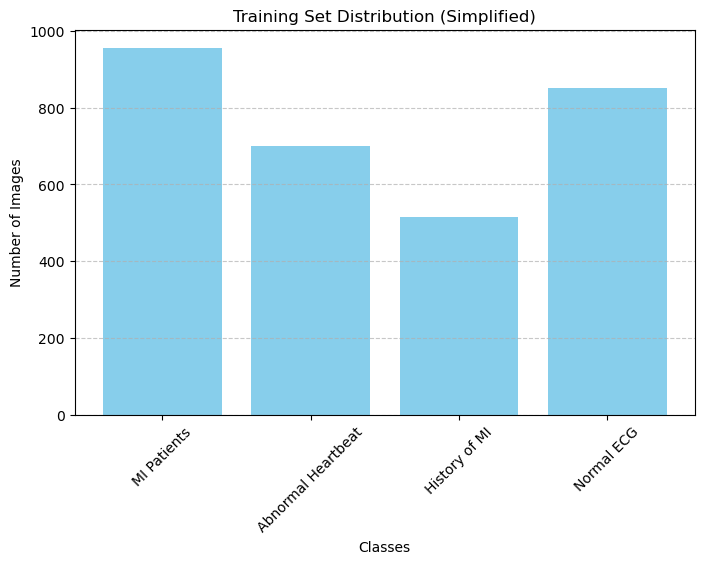

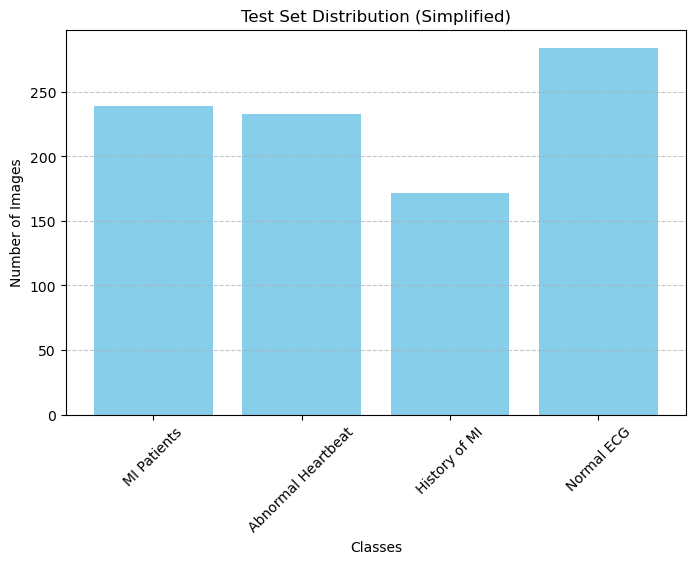

In [21]:
import matplotlib.pyplot as plt

# Function to plot class distribution
def plot_class_distribution(class_counts, title="Class Distribution"):
    plt.figure(figsize=(8, 5))
    plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Define simple class names
class_name_mapping = {
    "ECG Images of Myocardial Infarction Patients (240x12=2880)": "MI Patients",
    "ECG Images of Patient that have History of MI (172x12=2064)": "History of MI",
    "ECG Images of Patient that have abnormal heartbeat (233x12=2796)": "Abnormal Heartbeat",
    "Normal Person ECG Images (284x12=3408)": "Normal ECG"
}

# Update dataset class names with shorter versions
train_info_simple = {class_name_mapping.get(k, k): v for k, v in train_info.items()}
test_info_simple = {class_name_mapping.get(k, k): v for k, v in test_info.items()}

# Plot again with simple names
plot_class_distribution(train_info_simple, title="Training Set Distribution (Simplified)")
plot_class_distribution(test_info_simple, title="Test Set Distribution (Simplified)")

# Dataset Split: Train, Validation, Test

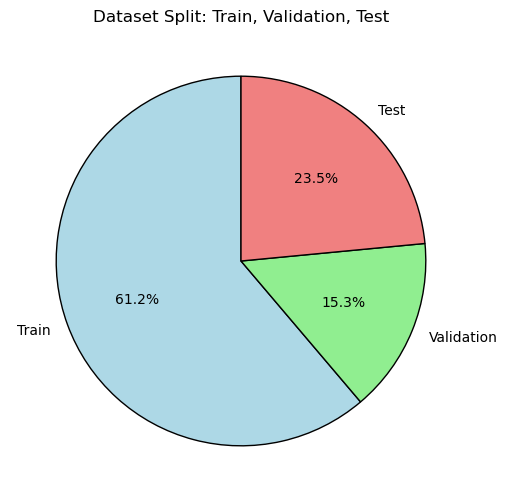

In [22]:
import matplotlib.pyplot as plt

# Dataset sizes
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

# Labels and sizes
labels = ["Train", "Validation", "Test"]
sizes = [train_size, val_size, test_size]
colors = ["lightblue", "lightgreen", "lightcoral"]

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title("Dataset Split: Train, Validation, Test")
plt.show()

# Sample Images from Each Class

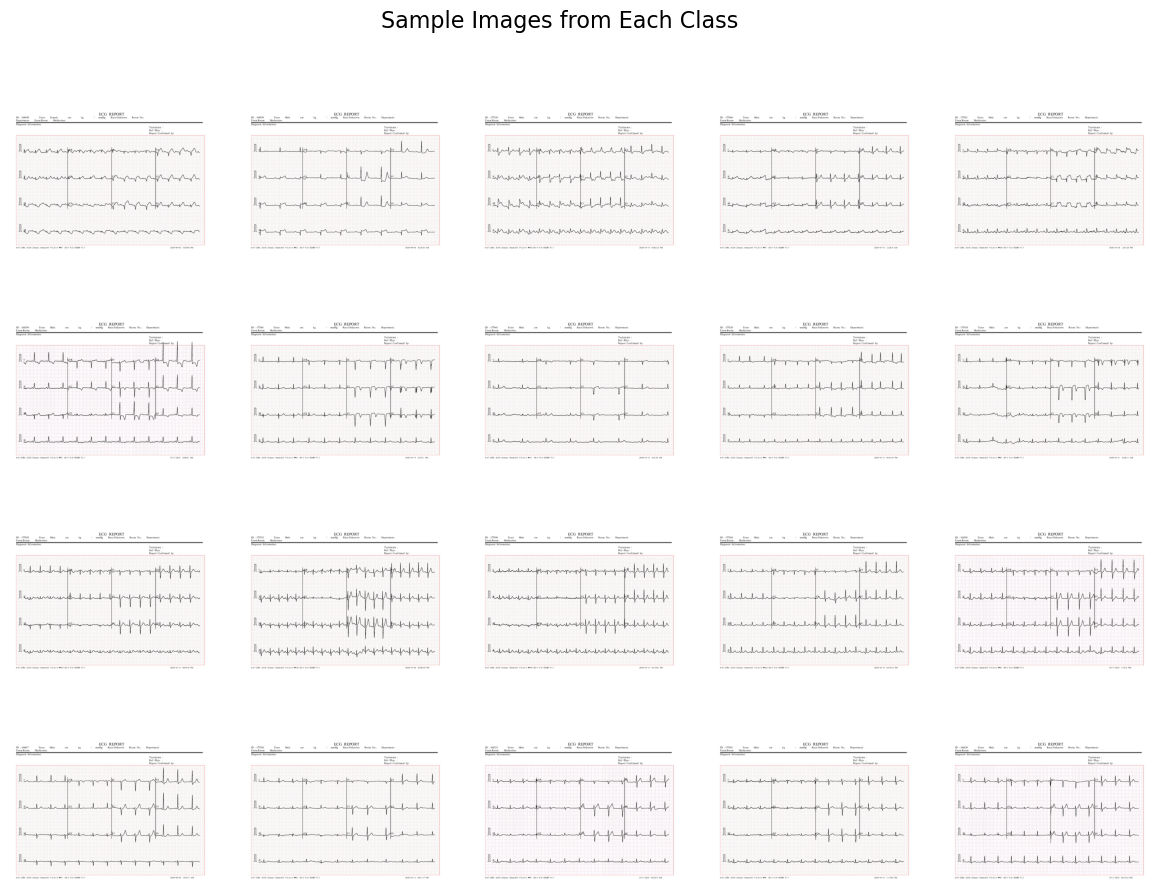

In [23]:
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Function to visualize sample images per class with larger images
def visualize_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(len(dataset.classes), num_samples, figsize=(15, 10))  # Increased figure size

    for i, class_name in enumerate(dataset.classes):
        class_indices = [idx for idx, (_, label) in enumerate(dataset.samples) if dataset.classes[label] == class_name]
        sampled_indices = random.sample(class_indices, min(num_samples, len(class_indices)))

        for j, idx in enumerate(sampled_indices):
            img_path, _ = dataset.samples[idx]
            img = Image.open(img_path)

            axes[i, j].imshow(img, cmap="gray")
            axes[i, j].axis("off")

        axes[i, 0].set_ylabel(class_name, rotation=90, size=14)  # Increased font size

    plt.subplots_adjust(wspace=0.05, hspace=0.5)  # Adjusted spacing to reduce empty space
    plt.suptitle("Sample Images from Each Class", fontsize=16)  # Increased title size
    plt.show()

# Show sample images from train dataset
visualize_samples(full_train_dataset)

# Image Size Distribution 

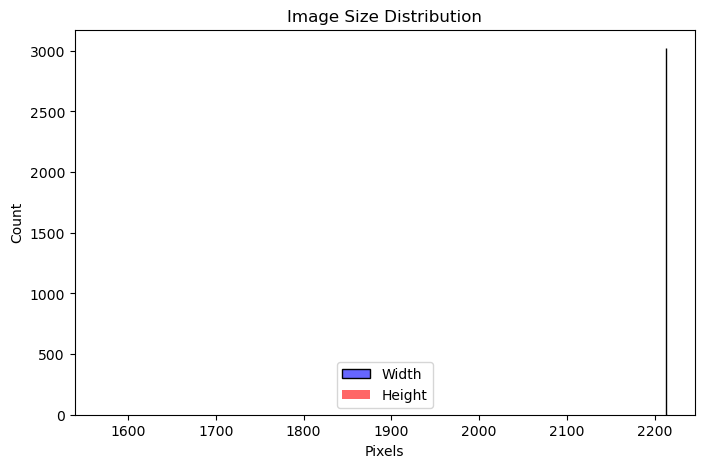

In [24]:
image_sizes = [Image.open(path).size for path, _ in full_train_dataset.samples]
widths, heights = zip(*image_sizes)

plt.figure(figsize=(8, 5))
sns.histplot(widths, bins=30, color="blue", alpha=0.6, label="Width")
sns.histplot(heights, bins=30, color="red", alpha=0.6, label="Height")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.title("Image Size Distribution")
plt.legend()
plt.show()

# Train the AlexNet Model

# AlexNet Model Loaded & Modified

In [25]:
alexnet = models.alexnet(pretrained=False)

# Modify the last fully connected layer for ECG classification
alexnet.classifier[6] = nn.Linear(4096, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet = alexnet.to(device)
print(alexnet)
# Print model summary
print("✅ AlexNet Model Loaded & Modified!")

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Train and store the AlexNet results

In [26]:
from tqdm import tqdm  

def train_model(model, train_loader, val_loader, num_epochs=5, lr=0.0001):
    model.to(device)
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []  
    train_accuracies = []  
    val_losses = []  
    val_accuracies = []  

    for epoch in range(num_epochs):
        # Training phase
        running_loss = 0.0
        correct = 0
        total = 0

        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=True)

        for images, labels in train_progress:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track training accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            train_progress.set_postfix(loss=running_loss / len(train_loader), accuracy=100 * correct / total)

        # Compute training metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=True)

        with torch.no_grad():
            for images, labels in val_progress:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                val_progress.set_postfix(loss=val_loss / len(val_loader), accuracy=100 * val_correct / val_total)

        # Compute validation metrics
        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_accuracy = 100 * val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)

        print(f"✅ Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_accuracy:.2f}% | "
              f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_accuracy:.2f}%")

        model.train()  # Set back to training mode

    print("✅ Training Completed!")
    
    return train_losses, train_accuracies, val_losses, val_accuracies

# Train and store results
train_losses, train_accuracies, val_losses, val_accuracies = train_model(alexnet, train_loader, val_loader, num_epochs=5)

Epoch 1/5 [Validation]: 100%|████████████████████████████████| 19/19 [00:40<00:00,  2.12s/it, accuracy=28.3, loss=1.36]


✅ Epoch 1/5 | Train Loss: 1.3691 | Train Acc: 30.44% | Val Loss: 1.3579 | Val Acc: 28.26%


Epoch 2/5 [Validation]: 100%|████████████████████████████████| 19/19 [00:40<00:00,  2.15s/it, accuracy=32.9, loss=1.36]


✅ Epoch 2/5 | Train Loss: 1.3658 | Train Acc: 29.74% | Val Loss: 1.3586 | Val Acc: 32.89%


Epoch 3/5 [Validation]: 100%|████████████████████████████████| 19/19 [00:51<00:00,  2.70s/it, accuracy=53.4, loss=1.05]


✅ Epoch 3/5 | Train Loss: 1.1369 | Train Acc: 47.56% | Val Loss: 1.0488 | Val Acc: 53.39%


Epoch 4/5 [Validation]: 100%|███████████████████████████████| 19/19 [00:40<00:00,  2.13s/it, accuracy=79.5, loss=0.462]


✅ Epoch 4/5 | Train Loss: 0.6490 | Train Acc: 73.45% | Val Loss: 0.4623 | Val Acc: 79.50%


Epoch 5/5 [Validation]: 100%|███████████████████████████████| 19/19 [00:41<00:00,  2.18s/it, accuracy=88.4, loss=0.308]

✅ Epoch 5/5 | Train Loss: 0.3960 | Train Acc: 84.12% | Val Loss: 0.3079 | Val Acc: 88.43%
✅ Training Completed!


# Train and Validation ( accuracy , loss ) views on AlexNet

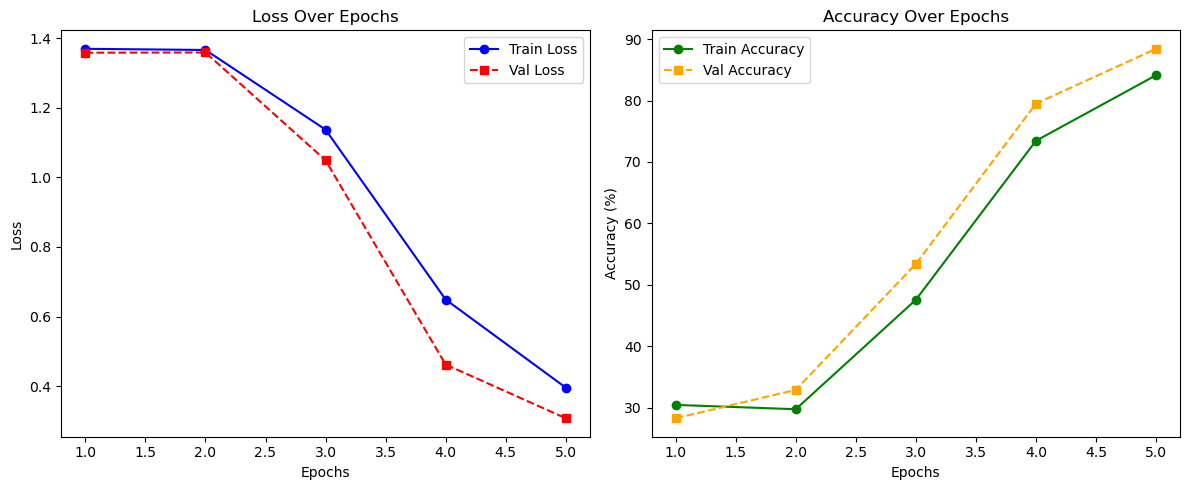

In [27]:
import matplotlib.pyplot as plt

def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o', linestyle='-', color='b', label="Train Loss")
    plt.plot(epochs, val_losses, marker='s', linestyle='--', color='r', label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, marker='o', linestyle='-', color='g', label="Train Accuracy")
    plt.plot(epochs, val_accuracies, marker='s', linestyle='--', color='orange', label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call function to plot
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies) 

# Evaluate the metrics on test dataset on AlexNet Model 


🔍 Evaluating Model...



Evaluating: 100%|█████████████████████████████████████████████████████| 29/29 [01:18<00:00,  2.72s/it, accuracy=88.36%]



🎯 **Final Evaluation Metrics:**
✅ **Accuracy:** 88.36%
✅ **Precision:** 88.71%
✅ **Recall:** 88.36%
✅ **F1 Score:** 88.50%



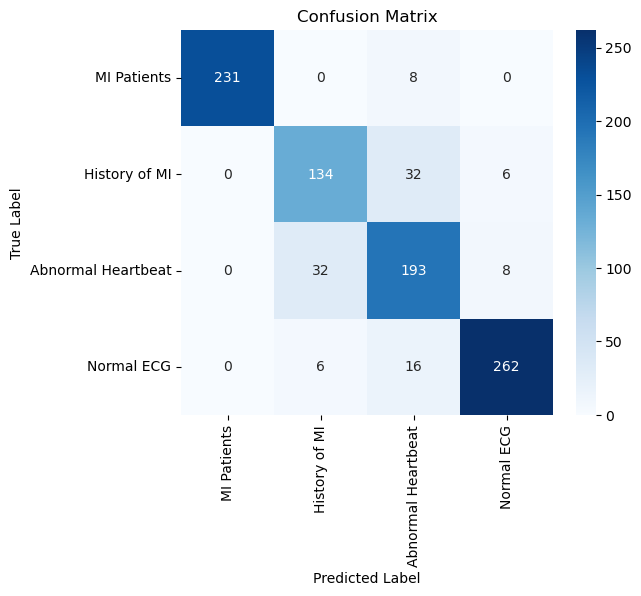

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import torch

# Define simple class names
class_names = ["MI Patients", "History of MI", "Abnormal Heartbeat", "Normal ECG"]

def evaluate_model_live(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    print("\n🔍 Evaluating Model...\n")
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Evaluating", leave=True)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Live Accuracy Update
            progress_bar.set_postfix(accuracy=f"{(100 * correct / total):.2f}%")

    # Calculate final metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average="weighted") * 100
    recall = recall_score(all_labels, all_preds, average="weighted") * 100
    f1 = f1_score(all_labels, all_preds, average="weighted") * 100

    print("\n🎯 **Final Evaluation Metrics:**")
    print(f"✅ **Accuracy:** {accuracy:.2f}%")
    print(f"✅ **Precision:** {precision:.2f}%")
    print(f"✅ **Recall:** {recall:.2f}%")
    print(f"✅ **F1 Score:** {f1:.2f}%\n")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Run evaluation with live progress updates
evaluate_model_live(alexnet, test_loader)

# Save the AlexNet Trained Model

In [29]:
# Save only model weights (Recommended)
torch.save(alexnet.state_dict(), "alexnet_ecg_weights.pth")
print("✅ Model weights saved successfully!")

# Save full model (Includes architecture)
torch.save(alexnet, "alexnet_ecg_full.pth")
print("✅ Full model saved successfully!")

✅ Model weights saved successfully!
✅ Full model saved successfully!


# Train the SqueezeNet Model

# SqueezeNet Model Loaded & Modified

In [30]:
# Load Pretrained SqueezeNet Model
squeezenet = models.squeezenet1_0(pretrained=False)

# Modify the classifier for ECG classification
squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1))
squeezenet.num_classes = num_classes

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
squeezenet = squeezenet.to(device)
print(squeezenet)
print("✅ SqueezeNet Model Loaded & Modified!")

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

# Train SqueezeNet and store results

In [31]:
### 🏋️ **Training Function with Validation**
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.0001):
    model.to(device)
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []  
    train_accuracies = []  
    val_losses = []  
    val_accuracies = []  

    for epoch in range(num_epochs):
        # Training phase
        running_loss = 0.0
        correct = 0
        total = 0

        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=True)

        for images, labels in train_progress:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track training accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            train_progress.set_postfix(loss=running_loss / len(train_loader), accuracy=100 * correct / total)

        # Compute training metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=True)

        with torch.no_grad():
            for images, labels in val_progress:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                val_progress.set_postfix(loss=val_loss / len(val_loader), accuracy=100 * val_correct / val_total)

        # Compute validation metrics
        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_accuracy = 100 * val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)

        print(f"✅ Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_accuracy:.2f}% | "
              f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_accuracy:.2f}%")

        model.train()  # Set back to training mode

    print("✅ Training Completed!")
    
    return train_losses, train_accuracies, val_losses, val_accuracies  

# Train SqueezeNet and store results
train_losses, train_accuracies, val_losses, val_accuracies = train_model(squeezenet, train_loader, val_loader, num_epochs=10)

Epoch 1/10 [Validation]: 100%|███████████████████████████████| 19/19 [00:51<00:00,  2.69s/it, accuracy=32.9, loss=1.34]


✅ Epoch 1/10 | Train Loss: 1.3687 | Train Acc: 30.44% | Val Loss: 1.3411 | Val Acc: 32.89%


Epoch 2/10 [Validation]: 100%|███████████████████████████████| 19/19 [00:51<00:00,  2.70s/it, accuracy=32.9, loss=1.35]


✅ Epoch 2/10 | Train Loss: 1.3478 | Train Acc: 33.62% | Val Loss: 1.3493 | Val Acc: 32.89%


Epoch 3/10 [Validation]: 100%|██████████████████████████████████| 19/19 [00:51<00:00,  2.71s/it, accuracy=38, loss=1.3]


✅ Epoch 3/10 | Train Loss: 1.2451 | Train Acc: 43.47% | Val Loss: 1.2967 | Val Acc: 38.02%


Epoch 4/10 [Validation]: 100%|███████████████████████████████| 19/19 [00:51<00:00,  2.71s/it, accuracy=34.4, loss=1.31]


✅ Epoch 4/10 | Train Loss: 1.1527 | Train Acc: 49.46% | Val Loss: 1.3112 | Val Acc: 34.38%


Epoch 5/10 [Validation]: 100%|██████████████████████████████| 19/19 [02:07<00:00,  6.73s/it, accuracy=66.6, loss=0.896]


✅ Epoch 5/10 | Train Loss: 1.0479 | Train Acc: 54.63% | Val Loss: 0.8963 | Val Acc: 66.61%


Epoch 6/10 [Validation]: 100%|██████████████████████████████| 19/19 [02:08<00:00,  6.78s/it, accuracy=69.8, loss=0.771]


✅ Epoch 6/10 | Train Loss: 0.8173 | Train Acc: 66.42% | Val Loss: 0.7713 | Val Acc: 69.75%


Epoch 7/10 [Validation]: 100%|██████████████████████████████| 19/19 [02:08<00:00,  6.79s/it, accuracy=64.6, loss=0.845]


✅ Epoch 7/10 | Train Loss: 0.7840 | Train Acc: 67.25% | Val Loss: 0.8447 | Val Acc: 64.63%


Epoch 8/10 [Validation]: 100%|██████████████████████████████| 19/19 [02:11<00:00,  6.90s/it, accuracy=74.7, loss=0.563]


✅ Epoch 8/10 | Train Loss: 0.6393 | Train Acc: 72.95% | Val Loss: 0.5626 | Val Acc: 74.71%


Epoch 9/10 [Validation]: 100%|██████████████████████████████| 19/19 [02:08<00:00,  6.78s/it, accuracy=85.3, loss=0.469]


✅ Epoch 9/10 | Train Loss: 0.5221 | Train Acc: 78.54% | Val Loss: 0.4688 | Val Acc: 85.29%


Epoch 10/10 [Validation]: 100%|█████████████████████████████| 19/19 [02:09<00:00,  6.83s/it, accuracy=81.5, loss=0.492]

✅ Epoch 10/10 | Train Loss: 0.5165 | Train Acc: 79.07% | Val Loss: 0.4921 | Val Acc: 81.49%
✅ Training Completed!


# Train and Validation ( accuracy , loss ) views on SqueezeNet Model

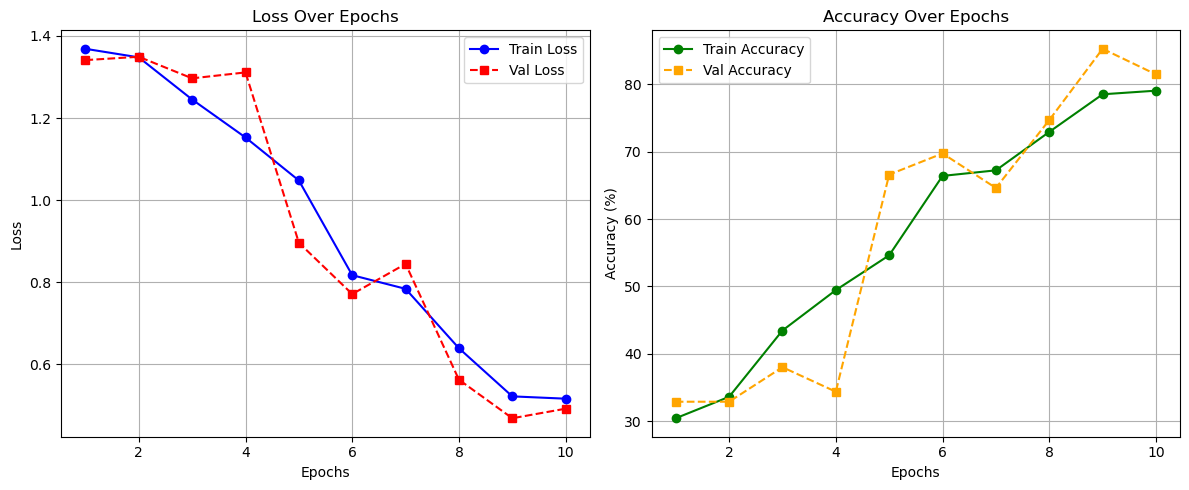

In [32]:
import matplotlib.pyplot as plt

### 📊 **Plot Loss & Accuracy Graphs**
def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o', linestyle='-', color='b', label="Train Loss")
    plt.plot(epochs, val_losses, marker='s', linestyle='--', color='r', label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, marker='o', linestyle='-', color='g', label="Train Accuracy")
    plt.plot(epochs, val_accuracies, marker='s', linestyle='--', color='orange', label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call function to plot graphs
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate the metrics on test dataset on SqueeZeNet Model


🔍 Evaluating Model...



Evaluating: 100%|█████████████████████████████████████████████████████| 29/29 [03:17<00:00,  6.83s/it, accuracy=81.25%]



🎯 **Final Evaluation Metrics:**
✅ **Accuracy:** 81.25%
✅ **Precision:** 82.85%
✅ **Recall:** 81.25%
✅ **F1 Score:** 81.01%



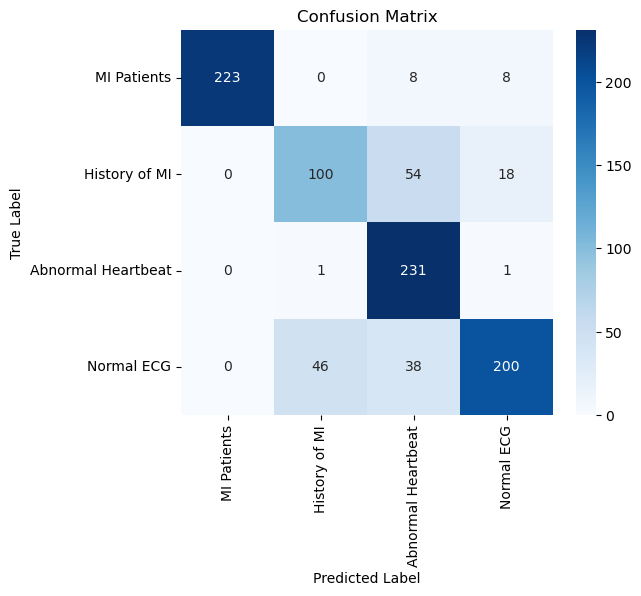

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import torch

# Define simple class names
class_names = ["MI Patients", "History of MI", "Abnormal Heartbeat", "Normal ECG"]

def evaluate_model_live(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    print("\n🔍 Evaluating Model...\n")
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Evaluating", leave=True)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Live Accuracy Update
            progress_bar.set_postfix(accuracy=f"{(100 * correct / total):.2f}%")

    # Calculate final metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average="weighted") * 100
    recall = recall_score(all_labels, all_preds, average="weighted") * 100
    f1 = f1_score(all_labels, all_preds, average="weighted") * 100

    print("\n🎯 **Final Evaluation Metrics:**")
    print(f"✅ **Accuracy:** {accuracy:.2f}%")
    print(f"✅ **Precision:** {precision:.2f}%")
    print(f"✅ **Recall:** {recall:.2f}%")
    print(f"✅ **F1 Score:** {f1:.2f}%\n")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Run evaluation with live progress updates for SqueezeNet
evaluate_model_live(squeezenet, test_loader)

# Save The Trained SqueeZeNet Model

In [34]:
### 💾 **Save Model**
# Save only model weights (Recommended)
torch.save(squeezenet.state_dict(), "squeezenet_ecg_weights.pth")
print("✅ Model weights saved successfully!")

# Save full model (Includes architecture)
torch.save(squeezenet, "squeezenet_ecg_full.pth")
print("✅ Full model saved successfully!")

✅ Model weights saved successfully!
✅ Full model saved successfully!


# Train The CNN Model

In [10]:
from torchsummary import summary

### **📌 Define Custom CNN Model**
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # Adjust for input size
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize CNN Model
cnn_model = CustomCNN(num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = cnn_model.to(device)

# Print model summary
summary(cnn_model, (3, 227, 227))  # Assuming input size (3, 227, 227)

print("✅ CNN Model Loaded & Ready for Training!")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 227, 227]             896
              ReLU-2         [-1, 32, 227, 227]               0
         MaxPool2d-3         [-1, 32, 113, 113]               0
            Conv2d-4         [-1, 64, 113, 113]          18,496
              ReLU-5         [-1, 64, 113, 113]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Linear-10                  [-1, 512]      51,380,736
             ReLU-11                  [-1, 512]               0
          Dropout-12                  [-1, 512]               0
           Linear-13                    [-1, 4]           2,052
Total params: 51,476,036
Trainable para

# Training CNN Model

In [11]:
from tqdm import tqdm

### 🏋️ **Training Function with Live Validation Progress**
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.0001):
    model.to(device)
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        running_loss, correct, total = 0.0, 0, 0

        progress_bar = tqdm(train_loader, desc=f" Epoch {epoch+1}/{num_epochs} (Training)", leave=True)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
            progress_bar.set_postfix(loss=running_loss / len(train_loader), accuracy=100 * correct / total)

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        # Validation Phase (LIVE Progress)
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        val_progress_bar = tqdm(val_loader, desc=f"🛠️ Epoch {epoch+1}/{num_epochs} (Validation)", leave=True)
        
        with torch.no_grad():
            for images, labels in val_progress_bar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                # Update live validation progress
                val_progress_bar.set_postfix(loss=val_loss / len(val_loader), accuracy=100 * val_correct / val_total)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * val_correct / val_total)

        print(f"\n✅ Epoch {epoch+1}/{num_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.2f}% | "
              f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]:.2f}%\n")

        model.train()

    print("🎉 **Training Completed!**")
    return train_losses, train_accuracies, val_losses, val_accuracies  

# Train CNN Model with Live Validation Progress
train_losses, train_accuracies, val_losses, val_accuracies = train_model(cnn_model, train_loader, val_loader, num_epochs=10)

🛠️ Epoch 1/10 (Validation): 100%|████████████████████████████| 19/19 [02:02<00:00,  6.46s/it, accuracy=65.5, loss=1.26]



✅ Epoch 1/10 | Train Loss: 1.3450 | Train Acc: 35.28% | Val Loss: 1.2624 | Val Acc: 65.45%



🛠️ Epoch 2/10 (Validation): 100%|███████████████████████████| 19/19 [01:58<00:00,  6.26s/it, accuracy=80.3, loss=0.628]



✅ Epoch 2/10 | Train Loss: 0.9696 | Train Acc: 63.94% | Val Loss: 0.6277 | Val Acc: 80.33%



🛠️ Epoch 3/10 (Validation): 100%|███████████████████████████| 19/19 [01:59<00:00,  6.30s/it, accuracy=90.6, loss=0.355]



✅ Epoch 3/10 | Train Loss: 0.5395 | Train Acc: 82.51% | Val Loss: 0.3550 | Val Acc: 90.58%



🛠️ Epoch 4/10 (Validation): 100%|███████████████████████████| 19/19 [02:02<00:00,  6.43s/it, accuracy=95.5, loss=0.199]



✅ Epoch 4/10 | Train Loss: 0.3409 | Train Acc: 90.12% | Val Loss: 0.1989 | Val Acc: 95.54%



🛠️ Epoch 5/10 (Validation): 100%|███████████████████████████| 19/19 [02:00<00:00,  6.32s/it, accuracy=95.9, loss=0.141]



✅ Epoch 5/10 | Train Loss: 0.2186 | Train Acc: 94.13% | Val Loss: 0.1410 | Val Acc: 95.87%



🛠️ Epoch 6/10 (Validation): 100%|███████████████████████████| 19/19 [01:59<00:00,  6.28s/it, accuracy=94.9, loss=0.129]



✅ Epoch 6/10 | Train Loss: 0.1552 | Train Acc: 95.86% | Val Loss: 0.1290 | Val Acc: 94.88%



🛠️ Epoch 7/10 (Validation): 100%|████████████████████████████| 19/19 [01:59<00:00,  6.28s/it, accuracy=98, loss=0.0671]



✅ Epoch 7/10 | Train Loss: 0.1126 | Train Acc: 96.82% | Val Loss: 0.0671 | Val Acc: 98.02%



🛠️ Epoch 8/10 (Validation): 100%|██████████████████████████| 19/19 [00:46<00:00,  2.43s/it, accuracy=99.3, loss=0.0319]



✅ Epoch 8/10 | Train Loss: 0.0716 | Train Acc: 97.97% | Val Loss: 0.0319 | Val Acc: 99.34%



🛠️ Epoch 9/10 (Validation): 100%|████████████████████████████| 19/19 [00:46<00:00,  2.44s/it, accuracy=99, loss=0.0334]



✅ Epoch 9/10 | Train Loss: 0.0420 | Train Acc: 99.05% | Val Loss: 0.0334 | Val Acc: 99.01%



🛠️ Epoch 10/10 (Validation): 100%|███████████████████████████| 19/19 [00:46<00:00,  2.44s/it, accuracy=100, loss=0.014]


✅ Epoch 10/10 | Train Loss: 0.0336 | Train Acc: 99.30% | Val Loss: 0.0140 | Val Acc: 100.00%

🎉 **Training Completed!**


# Train and Validation ( accuracy , loss ) views on CNN

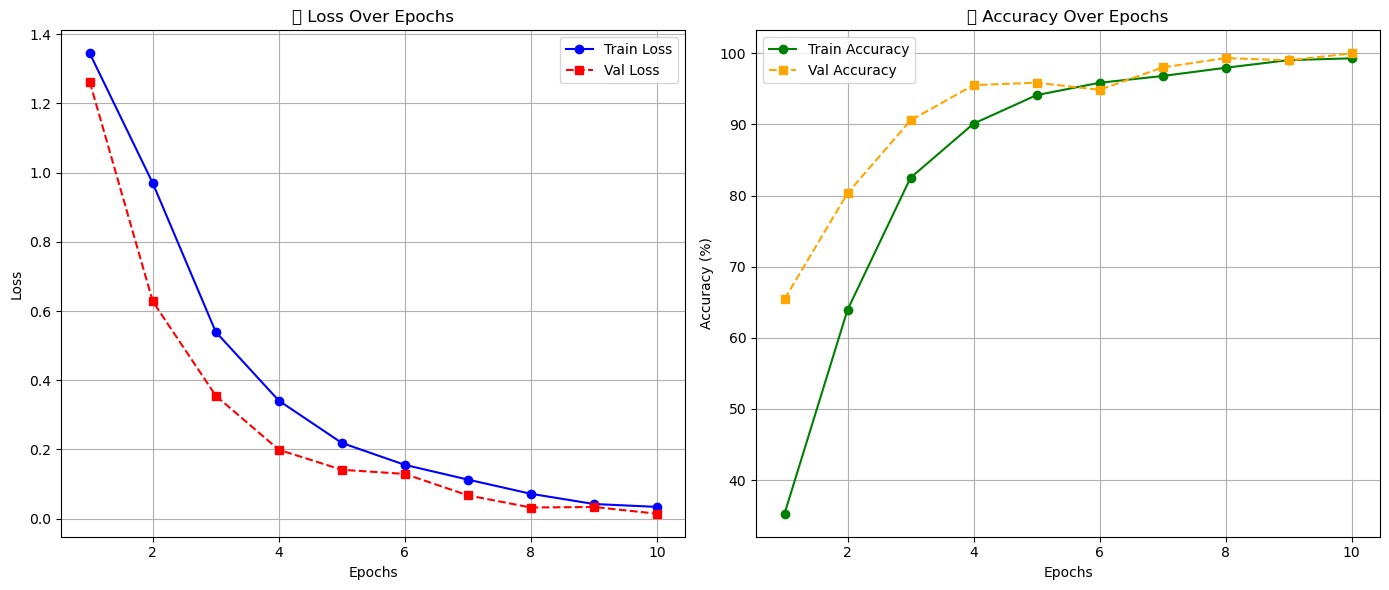

In [12]:
import matplotlib.pyplot as plt

### 📊 **Plot Training & Validation Curves**
def plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o', linestyle='-', color='b', label="Train Loss")
    plt.plot(epochs, val_losses, marker='s', linestyle='--', color='r', label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("📉 Loss Over Epochs")
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, marker='o', linestyle='-', color='g', label="Train Accuracy")
    plt.plot(epochs, val_accuracies, marker='s', linestyle='--', color='orange', label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("📈 Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call function to plot graphs
plot_training_curves(train_losses, train_accuracies, val_losses, val_accuracies)

# Evaluate the metrics on test dataset on CNN Model


🔍 Evaluating Model...



Evaluating: 100%|████████████████████████████████████████████████████| 29/29 [01:11<00:00,  2.48s/it, accuracy=100.00%]



🎯 **Final Evaluation Metrics:**
✅ **Accuracy:** 100.00%
✅ **Precision:** 100.00%
✅ **Recall:** 100.00%
✅ **F1 Score:** 100.00%



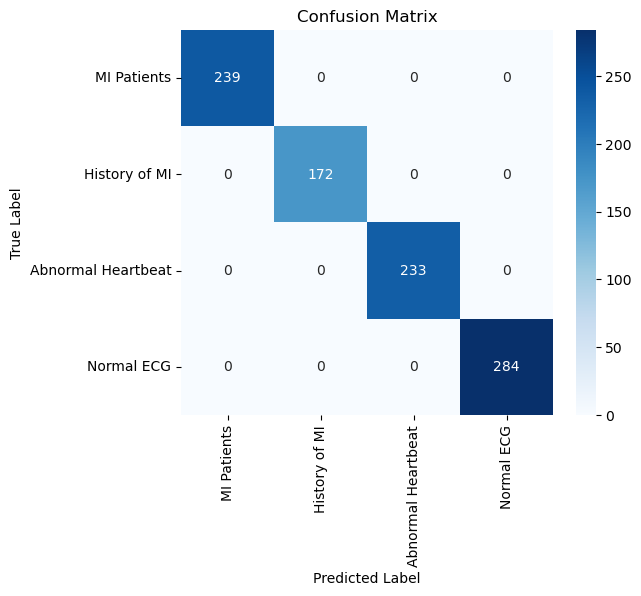

In [14]:
### 🔍 **Evaluate CNN Model & Confusion Matrix**
class_names = ["MI Patients", "History of MI", "Abnormal Heartbeat", "Normal ECG"]

def evaluate_model_live(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    print("\n🔍 Evaluating Model...\n")
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Evaluating", leave=True)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Live Accuracy Update
            progress_bar.set_postfix(accuracy=f"{(100 * correct / total):.2f}%")

    # Calculate final metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average="weighted") * 100
    recall = recall_score(all_labels, all_preds, average="weighted") * 100
    f1 = f1_score(all_labels, all_preds, average="weighted") * 100

    print("\n🎯 **Final Evaluation Metrics:**")
    print(f"✅ **Accuracy:** {accuracy:.2f}%")
    print(f"✅ **Precision:** {precision:.2f}%")
    print(f"✅ **Recall:** {recall:.2f}%")
    print(f"✅ **F1 Score:** {f1:.2f}%\n")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Run evaluation
evaluate_model_live(cnn_model, test_loader)

# Save the trained CNN Model

In [15]:
### 💾 **Save CNN Model**
torch.save(cnn_model.state_dict(), "cnn_ecg_weights.pth")
print("✅ CNN Model weights saved successfully!")

✅ CNN Model weights saved successfully!


# Model metrics collection for All Models

In [35]:
from tqdm import tqdm
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define a dictionary to store model metrics
model_metrics = {
    "Model": ["AlexNet", "SqueezeNet", "CNN"],
    "Accuracy (%)": [],
    "Precision (%)": [],
    "Recall (%)": [],
    "F1-Score (%)": []
}

# Function to evaluate and store metrics with live progress
def get_model_metrics_live(model, test_loader, model_name="Model"):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    print(f"\n🔍 Evaluating {model_name}...\n")
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc=f"Evaluating {model_name}", leave=True)
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Live Accuracy Update
            progress_bar.set_postfix(accuracy=f"{(100 * correct / total):.2f}%")

    # Compute final metrics
    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average="weighted") * 100
    recall = recall_score(all_labels, all_preds, average="weighted") * 100
    f1 = f1_score(all_labels, all_preds, average="weighted") * 100

    print(f"\n✅ {model_name} Evaluation Completed!")
    print(f"🎯 Accuracy: {accuracy:.2f}%")
    print(f"🎯 Precision: {precision:.2f}%")
    print(f"🎯 Recall: {recall:.2f}%")
    print(f"🎯 F1-Score: {f1:.2f}%\n")

    return accuracy, precision, recall, f1

# Get live metrics for each model
alexnet_metrics = get_model_metrics_live(alexnet, test_loader, "AlexNet")
squeezenet_metrics = get_model_metrics_live(squeezenet, test_loader, "SqueezeNet")
cnn_metrics = get_model_metrics_live(cnn_model, test_loader, "CNN")

# Store results in dictionary
model_metrics["Accuracy (%)"].extend([alexnet_metrics[0], squeezenet_metrics[0], cnn_metrics[0]])
model_metrics["Precision (%)"].extend([alexnet_metrics[1], squeezenet_metrics[1], cnn_metrics[1]])
model_metrics["Recall (%)"].extend([alexnet_metrics[2], squeezenet_metrics[2], cnn_metrics[2]])
model_metrics["F1-Score (%)"].extend([alexnet_metrics[3], squeezenet_metrics[3], cnn_metrics[3]])

print("✅ Model metrics collected successfully!")


🔍 Evaluating AlexNet...



Evaluating AlexNet: 100%|█████████████████████████████████████████████| 29/29 [02:37<00:00,  5.42s/it, accuracy=88.36%]



✅ AlexNet Evaluation Completed!
🎯 Accuracy: 88.36%
🎯 Precision: 88.71%
🎯 Recall: 88.36%
🎯 F1-Score: 88.50%


🔍 Evaluating SqueezeNet...



Evaluating SqueezeNet: 100%|██████████████████████████████████████████| 29/29 [03:22<00:00,  6.98s/it, accuracy=81.25%]



✅ SqueezeNet Evaluation Completed!
🎯 Accuracy: 81.25%
🎯 Precision: 82.85%
🎯 Recall: 81.25%
🎯 F1-Score: 81.01%


🔍 Evaluating CNN...



Evaluating CNN: 100%|████████████████████████████████████████████████| 29/29 [03:03<00:00,  6.32s/it, accuracy=100.00%]


✅ CNN Evaluation Completed!
🎯 Accuracy: 100.00%
🎯 Precision: 100.00%
🎯 Recall: 100.00%
🎯 F1-Score: 100.00%

✅ Model metrics collected successfully!


In [36]:
import pandas as pd

# Convert dictionary to DataFrame
df_metrics = pd.DataFrame(model_metrics)

# Display the table
print(df_metrics)

        Model  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)
0     AlexNet     88.362069      88.706099   88.362069     88.498721
1  SqueezeNet     81.250000      82.848526   81.250000     81.005478
2         CNN    100.000000     100.000000  100.000000    100.000000


# Plot The Metrics

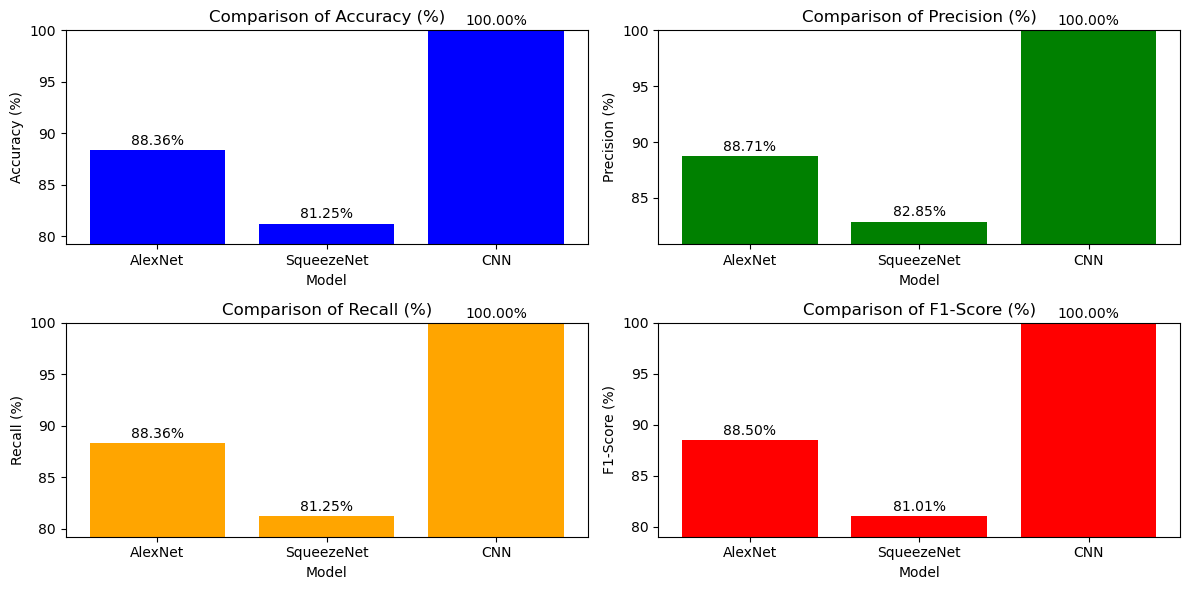

In [37]:
import matplotlib.pyplot as plt

# Set figure size
plt.figure(figsize=(12, 6))

# Plot Accuracy, Precision, Recall, and F1-Score
metrics = ["Accuracy (%)", "Precision (%)", "Recall (%)", "F1-Score (%)"]
colors = ["blue", "green", "orange", "red"]

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.bar(df_metrics["Model"], df_metrics[metric], color=colors[i])
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.title(f"Comparison of {metric}")
    plt.ylim([min(df_metrics[metric]) - 2, 100])  # Adjust y-axis for better visualization
    for index, value in enumerate(df_metrics[metric]):
        plt.text(index, value + 0.5, f"{value:.2f}%", ha="center", fontsize=10)

plt.tight_layout()
plt.show()

# Load The All Train Saved Models

In [38]:
import torch
from torchvision import models

# Define the number of classes
num_classes = 4  # Update this according to your dataset

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load AlexNet
alexnet = models.alexnet(pretrained=False)
alexnet.classifier[6] = torch.nn.Linear(4096, num_classes)  # Adjust last layer
alexnet.load_state_dict(torch.load("alexnet_ecg_weights.pth", map_location=device))
alexnet = alexnet.to(device)
alexnet.eval()
print("✅ AlexNet Loaded Successfully!")

# Load SqueezeNet
squeezenet = models.squeezenet1_0(pretrained=False)
squeezenet.classifier[1] = torch.nn.Conv2d(512, num_classes, kernel_size=(1, 1))
squeezenet.load_state_dict(torch.load("squeezenet_ecg_weights.pth", map_location=device))
squeezenet = squeezenet.to(device)
squeezenet.eval()
print("✅ SqueezeNet Loaded Successfully!")

# Define Custom CNN Model
class CustomCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(128 * 28 * 28, 512)
        self.fc2 = torch.nn.Linear(512, num_classes)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Load Custom CNN
cnn_model = CustomCNN(num_classes)
cnn_model.load_state_dict(torch.load("cnn_ecg_weights.pth", map_location=device))
cnn_model = cnn_model.to(device)
cnn_model.eval()
print("✅ Custom CNN Loaded Successfully!")

# Store models in a dictionary
models_dict = {
    "AlexNet": alexnet,
    "SqueezeNet": squeezenet,
    "CustomCNN": cnn_model
}

print("All models loaded")

✅ AlexNet Loaded Successfully!
✅ SqueezeNet Loaded Successfully!
✅ Custom CNN Loaded Successfully!
All models loaded


# Function to test Prections with all trained models on Unseen Data(u have to give image path it will predicts the class)

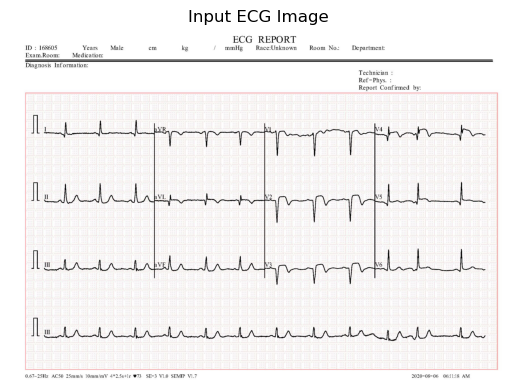


🔍 Predicting for: C:/Users/konde/OneDrive/Desktop/learn/term paper/ECG_DATA/test/ECG Images of Patient that have History of MI (172x12=2064)/PMI(10).jpg
✅ AlexNet Prediction: MI Patients
✅ SqueezeNet Prediction: Abnormal Heartbeat
✅ CustomCNN Prediction: History of MI


In [44]:
# import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Define the number of classes and class labels
num_classes = 4
class_labels = ["MI Patients", "History of MI", "Abnormal Heartbeat", "Normal ECG"]

# Define image preprocessing steps (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

# Function to predict using all models and display image
def predict_with_all_models(image_path):
    # Load image
    image = Image.open(image_path).convert("RGB")
    
    # Display the image
    plt.imshow(image)
    plt.axis("off")  # Hide axes
    plt.title("Input ECG Image")
    plt.show()
    
    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    print(f"\n🔍 Predicting for: {image_path}")

    # Iterate over all models and make predictions
    for model_name, model in models_dict.items():
        model.eval()
        with torch.no_grad():
            output = model(image_tensor)
            predicted_class = torch.argmax(output, dim=1).item()
        
        print(f"✅ {model_name} Prediction: {class_labels[predicted_class]}")

# Example Usage
image_path = "C:/Users/konde/OneDrive/Desktop/learn/term paper/ECG_DATA/test/ECG Images of Patient that have History of MI (172x12=2064)/PMI(10).jpg"
#"/kaggle/input/ecg-images/ECG_DATA/test/ECG Images of Patient that have History of MI (172x12=2064)/PMI(10).jpg"  # Update this path
predict_with_all_models(image_path)

# Function To test on Unseen Data. It will Predict class and take Majority Voting from all trained models(AlexNet,SqueezeNet,CNN)

In [45]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter

# Define the number of classes and class labels
num_classes = 4
class_labels = ["MI Patients", "History of MI", "Abnormal Heartbeat", "Normal ECG"]

# Define image preprocessing steps (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

# Function to predict using all models and apply majority voting
def predict_with_majority_voting(image_path):
    # Load image
    image = Image.open(image_path).convert("RGB")
    
    # Display the image
    plt.imshow(image)
    plt.axis("off")  # Hide axes
    plt.title("Input ECG Image")
    plt.show()
    
    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    print(f"\n🔍 Predicting for: {image_path}")

    # Store predictions from all models
    predictions = []

    # Iterate over all models and make predictions
    for model_name, model in models_dict.items():
        model.eval()
        with torch.no_grad():
            output = model(image_tensor)
            predicted_class = torch.argmax(output, dim=1).item()
            predictions.append(predicted_class)
        
        print(f"✅ {model_name} Prediction: {class_labels[predicted_class]}")

    # Majority voting
    most_common_class = Counter(predictions).most_common(1)[0][0]
    final_prediction = class_labels[most_common_class]

    print("\n🎯 Final Prediction (Majority Vote):", final_prediction)

# Give image path to predict the output

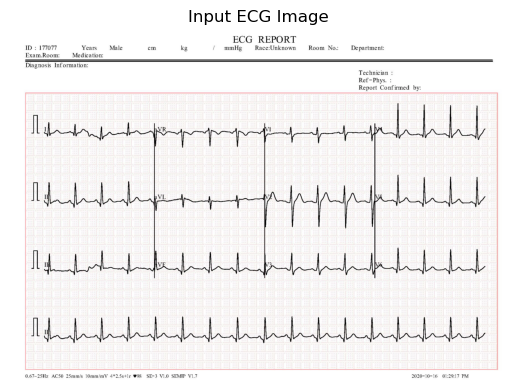


🔍 Predicting for: C:/Users/konde/OneDrive/Desktop/learn/term paper/ECG_DATA/test/ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(100).jpg
✅ AlexNet Prediction: Abnormal Heartbeat
✅ SqueezeNet Prediction: Abnormal Heartbeat
✅ CustomCNN Prediction: Abnormal Heartbeat

🎯 Final Prediction (Majority Vote): Abnormal Heartbeat


In [46]:
# Example Usage
image_path = "C:/Users/konde/OneDrive/Desktop/learn/term paper/ECG_DATA/test/ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(100).jpg"
#"/kaggle/input/ecg-images/ECG_DATA/test/ECG Images of Patient that have abnormal heartbeat (233x12=2796)/HB(100).jpg"  # Update this path
predict_with_majority_voting(image_path)